In [ ]:
%pip install seaborn matplotlib

  Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp313-cp313-win_amd64.whl.metadata (116 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp313-cp313-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl (73 kB)

   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- -----

In [1]:
%pip install protobuf

In [2]:
%pip install accelerate>=0.26.0

KeyboardInterrupt: 

In [ ]:
%pip install datasets

  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached anyio-4.12.1-py3-none-any.whl.metadata (4.3 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
  Using cached h11-0.16.0-py3-none-any.whl.metadata (8.3 kB)
Using cached httpx-0.28.1-py3-none-any.whl (73 kB)
Using cached httpcore-1.0.9-py3-none-any.whl (78 kB)
Using cached h11-0.16.0-py3-none-any.whl (37 kB)
   ---------------------------------------- 0.0/27.6 MB ? eta -:--:--
   ---- ----------------------------------- 3.1/27.6 MB 17.9 MB/s eta 0:00:02
   -------- ------------------------------- 6.0/27.6 MB 15.4 MB/s eta 0:00:02
   -------------- ------------------------- 10.2/27.6 MB 16.9 MB/s eta 0:00:02
   ------------------- -------------------- 13.1/27.6 MB 16.2 MB/s eta 0:00:01
   ---------------------- ----------------- 15.2/27.6 MB 15.1 MB/s eta 0:00:01
   ------------------------- -------------- 17.6/27.6 MB 14.4 MB/s eta 0:00:01
   ---------------------------- ----------- 19.9/27.6 

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset as HFDataset
from torch.utils.data import TensorDataset

In [5]:
MODEL_NAME = "microsoft/mdeberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [7]:
TRAIN_FILE = 'balanced_dataset_train.csv'
VAL_FILE = 'val_split.csv'
TEST_FILE = 'test_split.csv'

In [8]:
train_df = pd.read_csv(TRAIN_FILE)
val_df = pd.read_csv(VAL_FILE)
test_df = pd.read_csv(TEST_FILE)

In [10]:
all_labels = pd.concat([train_df['label'], val_df['label'], test_df['label']]).unique()
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

label2id = {label: int(i) for i, label in enumerate(label_encoder.classes_)}
id2label = {int(i): label for i, label in enumerate(label_encoder.classes_)}

In [11]:
train_df['label_id'] = label_encoder.transform(train_df['label']).astype(int)
val_df['label_id'] = label_encoder.transform(val_df['label']).astype(int)
test_df['label_id'] = label_encoder.transform(test_df['label']).astype(int)

In [12]:
import re

def clean_text(text):
    text = str(text)
    text = re.sub(r'\[[A-Z]+\]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['text'] = train_df['text'].apply(clean_text)
val_df['text'] = val_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)
train_df = train_df[train_df['text'] != '']
val_df = val_df[val_df['text'] != '']
test_df = test_df[test_df['text'] != '']

In [13]:
train_df['text'] = train_df['text'].astype(str)
val_df['text'] = val_df['text'].astype(str)
test_df['text'] = test_df['text'].astype(str)

train_df = train_df[train_df['text'] != 'nan']
val_df = val_df[val_df['text'] != 'nan']
test_df = test_df[test_df['text'] != 'nan']

In [15]:
class EmotionDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.texts = df['text'].astype(str).tolist()
        self.labels = df['label_id'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = EmotionDataset(train_df, tokenizer)
val_dataset = EmotionDataset(val_df, tokenizer)
test_dataset = EmotionDataset(test_df, tokenizer)

In [16]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

print(f"Class Weights: {class_weights_tensor}")

Class Weights: tensor([1.6296, 0.9057, 1.6299, 0.5049, 1.4535], device='cuda:0')


In [17]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):

        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        labels = inputs.get("labels")

        outputs = model(**inputs)

        if hasattr(outputs, "logits"):
            logits = outputs.logits
        else:
            logits = outputs[0]

        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor.to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1_macro': f1,
        'precision_macro': precision,
        'recall_macro': recall
    }

In [18]:
from transformers import AutoConfig

config = AutoConfig.from_pretrained(
    "microsoft/mdeberta-v3-base",
    num_labels=5,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)

In [19]:
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/mdeberta-v3-base",
    config=config
).to(DEVICE)

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    weight_decay=0.1,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=4
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [21]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [22]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
0
Tesla T4


In [23]:
import transformers
print("Starting training...")
transformers.logging.set_verbosity_info()
trainer.train()
model.save_pretrained("./final_emotion_model")
tokenizer.save_pretrained("./final_emotion_model")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
***** Running training *****
  Num examples = 48,889
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 15,280
  Number of trainable parameters = 278,813,189
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Starting training...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"
wandb: Using W&B in offline mode.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,1.008300,1.233895,0.407787,0.353228,0.366314,0.465669
2,0.815100,1.163507,0.515177,0.436294,0.429616,0.479628
3,0.753800,1.151278,0.516852,0.452776,0.435174,0.507984
4,0.747700,1.138559,0.537785,0.475030,0.457156,0.522190
5,0.732800,1.135352,0.563952,0.495166,0.476626,0.526658



***** Running Evaluation *****
  Num examples = 4777
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-3056
Configuration saved in ./results/checkpoint-3056/config.json
Model weights saved in ./results/checkpoint-3056/model.safetensors
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(

***** Running Evaluation *****
  Num examples = 4777
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-6112
Configuration saved in ./results/checkpoint-6112/config.json
Model weights saved in ./results/checkpoint-6112/model.safetensors
/usr/local/lib/python3.12/dist-packages

('./final_emotion_model/tokenizer_config.json',
 './final_emotion_model/special_tokens_map.json',
 './final_emotion_model/spm.model',
 './final_emotion_model/added_tokens.json',
 './final_emotion_model/tokenizer.json')

In [30]:
model = AutoModelForSequenceClassification.from_pretrained(
    './results/checkpoint-15280',# "microsoft/mdeberta-v3-base"
    num_labels=len(label_encoder.classes_),
    id2label=id2label,
    label2id=label2id
)

args = TrainingArguments(
    output_dir="./results",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    dataloader_num_workers=2,
    fp16=True,
)

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

print("Resuming training...")
transformers.logging.set_verbosity_info()
trainer.train(resume_from_checkpoint=True)
model.save_pretrained("./final_emotion_model")
tokenizer.save_pretrained("./final_emotion_model")

loading configuration file ./results/checkpoint-15280/config.json
Model config DebertaV2Config {
  "architectures": [
    "DebertaV2ForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.3,
  "dtype": "float32",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 768,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "fear",
    "3": "joy",
    "4": "sadness"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "fear": 2,
    "joy": 3,
    "sadness": 4
  },
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "pos

Resuming training...


***** Running training *****
  Num examples = 48,889
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 30,560
  Number of trainable parameters = 278,813,189
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 5
  Continuing training from global step 15280
  Will skip the first 5 epochs then the first 0 batches in the first epoch.
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
6,0.726200,1.129548,0.574838,0.506577,0.496380,0.524174
7,0.691900,1.129890,0.568767,0.502043,0.495175,0.517150
8,0.634200,1.160824,0.583630,0.512194,0.504222,0.525088
9,0.641300,1.152185,0.588654,0.512785,0.509431,0.521165
10,0.639900,1.154463,0.579234,0.511121,0.503357,0.525743



***** Running Evaluation *****
  Num examples = 4777
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-18336
Configuration saved in ./results/checkpoint-18336/config.json
Model weights saved in ./results/checkpoint-18336/model.safetensors

***** Running Evaluation *****
  Num examples = 4777
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-21392
Configuration saved in ./results/checkpoint-21392/config.json
Model weights saved in ./results/checkpoint-21392/model.safetensors

***** Running Evaluation *****
  Num examples = 4777
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-24448
Configuration saved in ./results/checkpoint-24448/config.json
Model weights saved in ./results/checkpoint-24448/model.safetensors

***** Running Evaluation *****
  Num examples = 4777
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-27504
Configuration saved in ./results/checkpoint-27504/config.json
Model weights saved in ./results/checkpoint-

('./final_emotion_model/tokenizer_config.json',
 './final_emotion_model/special_tokens_map.json',
 './final_emotion_model/spm.model',
 './final_emotion_model/added_tokens.json',
 './final_emotion_model/tokenizer.json')

In [31]:
preds_output = trainer.predict(test_dataset)
y_pred = preds_output.predictions.argmax(-1)
y_true = preds_output.label_ids


***** Running Prediction *****
  Num examples = 4779
  Batch size = 16


In [32]:
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       anger       0.44      0.54      0.48       325
anticipation       0.45      0.59      0.51      1296
        fear       0.15      0.19      0.17        42
         joy       0.70      0.52      0.60      2406
     sadness       0.54      0.65      0.59       710

    accuracy                           0.56      4779
   macro avg       0.46      0.50      0.47      4779
weighted avg       0.59      0.56      0.56      4779



In [33]:
results_df = pd.DataFrame({
    'lang': test_df['lang'].values,
    'true_id': y_true,
    'pred_id': y_pred
})

In [34]:
results_df['true_label'] = label_encoder.inverse_transform(results_df['true_id'])
results_df['pred_label'] = label_encoder.inverse_transform(results_df['pred_id'])


 DETAILED REPORT BY LANGUAGE 
--- Language: en (Count: 294) ---
Accuracy: 0.554
------------------------------
--- Language: es (Count: 295) ---
Accuracy: 0.593
------------------------------
--- Language: fr (Count: 653) ---
Accuracy: 0.609
------------------------------
--- Language: id (Count: 620) ---
Accuracy: 0.555
------------------------------
--- Language: it (Count: 668) ---
Accuracy: 0.500
------------------------------
--- Language: km (Count: 98) ---
Accuracy: 0.480
------------------------------
--- Language: ms (Count: 490) ---
Accuracy: 0.535
------------------------------
--- Language: pt (Count: 293) ---
Accuracy: 0.693
------------------------------
--- Language: th (Count: 382) ---
Accuracy: 0.568
------------------------------
--- Language: tl (Count: 296) ---
Accuracy: 0.480
------------------------------
--- Language: vi (Count: 396) ---
Accuracy: 0.487
------------------------------
--- Language: zh (Count: 294) ---
Accuracy: 0.609
-----------------------------

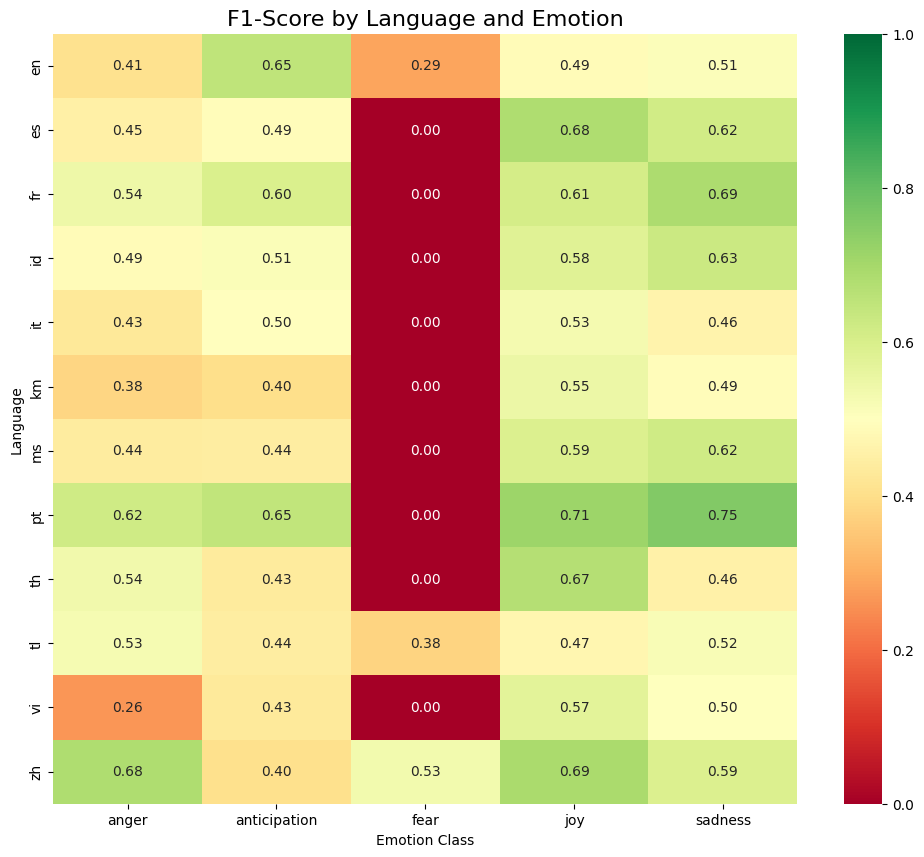

In [35]:
unique_langs = results_df['lang'].unique()
print(f"\n{'='*20}\n DETAILED REPORT BY LANGUAGE \n{'='*20}")
f1_matrix = []
for lang in sorted(unique_langs):
    subset = results_df[results_df['lang'] == lang]
    report = classification_report(
        subset['true_label'],
        subset['pred_label'],
        labels=label_encoder.classes_,
        output_dict=True,
        zero_division=0
    )

    print(f"--- Language: {lang} (Count: {len(subset)}) ---")
    print(f"Accuracy: {report['accuracy']:.3f}")

    row = {'lang': lang}
    for label in label_encoder.classes_:
        row[label] = report[label]['f1-score']

    f1_matrix.append(row)
    print("-" * 30)

heatmap_df = pd.DataFrame(f1_matrix).set_index('lang')
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_df, annot=True, cmap='RdYlGn', fmt='.2f', vmin=0, vmax=1)
plt.title('F1-Score by Language and Emotion', fontsize=16)
plt.xlabel('Emotion Class')
plt.ylabel('Language')
plt.show()

In [ ]:
preds_output1 = trainer.predict(test_dataset1)
y_pred1 = preds_output1.predictions.argmax(-1)
y_true1 = preds_output1.label_ids

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(

***** Running Prediction *****
  Num examples = 9214
  Batch size = 16


In [ ]:
print(classification_report(y_true1, y_pred1, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       anger       0.36      0.63      0.46       677
anticipation       0.43      0.60      0.50      2452
        fear       0.09      0.19      0.12        70
         joy       0.70      0.39      0.51      4623
     sadness       0.49      0.67      0.57      1392

    accuracy                           0.51      9214
   macro avg       0.42      0.50      0.43      9214
weighted avg       0.57      0.51      0.51      9214



In [ ]:
results_df1 = pd.DataFrame({
    'lang': test_df1['lang'].values,
    'true_id': y_true1,
    'pred_id': y_pred1
})

In [ ]:
results_df1['true_label'] = label_encoder.inverse_transform(results_df1['true_id'])
results_df1['pred_label'] = label_encoder.inverse_transform(results_df1['pred_id'])


 DETAILED REPORT BY LANGUAGE 
--- Language: bn (Count: 130) ---
Accuracy: 0.492
------------------------------
--- Language: de (Count: 807) ---
Accuracy: 0.509
------------------------------
--- Language: en (Count: 481) ---
Accuracy: 0.505
------------------------------
--- Language: es (Count: 468) ---
Accuracy: 0.549
------------------------------
--- Language: fr (Count: 983) ---
Accuracy: 0.535
------------------------------
--- Language: hi (Count: 272) ---
Accuracy: 0.511
------------------------------
--- Language: id (Count: 902) ---
Accuracy: 0.477
------------------------------
--- Language: it (Count: 1041) ---
Accuracy: 0.453
------------------------------
--- Language: km (Count: 161) ---
Accuracy: 0.472
------------------------------
--- Language: ms (Count: 700) ---
Accuracy: 0.496
------------------------------
--- Language: my (Count: 144) ---
Accuracy: 0.424
------------------------------
--- Language: nl (Count: 351) ---
Accuracy: 0.558
---------------------------

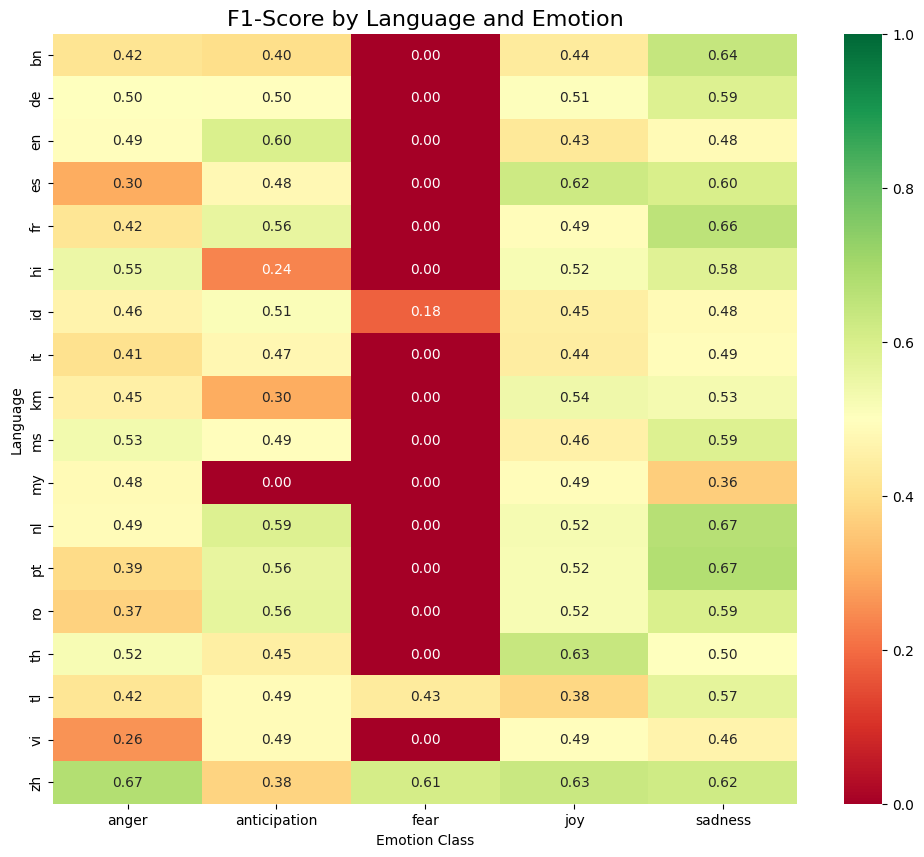

In [ ]:
unique_langs = results_df1['lang'].unique()
print(f"\n{'='*20}\n DETAILED REPORT BY LANGUAGE \n{'='*20}")
f1_matrix = []
for lang in sorted(unique_langs):
    subset = results_df1[results_df1['lang'] == lang]
    report = classification_report(
        subset['true_label'],
        subset['pred_label'],
        labels=label_encoder.classes_,
        output_dict=True,
        zero_division=0
    )

    print(f"--- Language: {lang} (Count: {len(subset)}) ---")
    print(f"Accuracy: {report['accuracy']:.3f}")

    row = {'lang': lang}
    for label in label_encoder.classes_:
        row[label] = report[label]['f1-score']

    f1_matrix.append(row)
    print("-" * 30)

heatmap_df = pd.DataFrame(f1_matrix).set_index('lang')
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_df, annot=True, cmap='RdYlGn', fmt='.2f', vmin=0, vmax=1)
plt.title('F1-Score by Language and Emotion', fontsize=16)
plt.xlabel('Emotion Class')
plt.ylabel('Language')
plt.show()

In [ ]:
!zip -r results.zip results/checkpoint-7620

  adding: results/checkpoint-7620/ (stored 0%)
  adding: results/checkpoint-7620/config.json (deflated 57%)
  adding: results/checkpoint-7620/model.safetensors (deflated 19%)
  adding: results/checkpoint-7620/optimizer.pt (deflated 57%)
  adding: results/checkpoint-7620/scheduler.pt (deflated 61%)
  adding: results/checkpoint-7620/rng_state.pth (deflated 26%)
  adding: results/checkpoint-7620/training_args.bin (deflated 53%)
  adding: results/checkpoint-7620/trainer_state.json (deflated 76%)
  adding: results/checkpoint-7620/scaler.pt (deflated 64%)


In [36]:
from google.colab import drive
drive.mount('/content/drive')

# Копируем архив на ваш Гугл Диск
!cp results/checkpoint-27504/ /content/drive/MyDrive/
print("Файл скопирован на Google Drive!")

Mounted at /content/drive
cp: -r not specified; omitting directory 'results/checkpoint-27504/'
Файл скопирован на Google Drive!


In [38]:
!zip -r model.zip results/checkpoint-27504/

  adding: results/checkpoint-27504/ (stored 0%)
  adding: results/checkpoint-27504/model.safetensors (deflated 19%)
  adding: results/checkpoint-27504/config.json (deflated 55%)
  adding: results/checkpoint-27504/training_args.bin (deflated 53%)
  adding: results/checkpoint-27504/rng_state.pth (deflated 26%)
  adding: results/checkpoint-27504/optimizer.pt (deflated 57%)
  adding: results/checkpoint-27504/trainer_state.json (deflated 80%)
  adding: results/checkpoint-27504/scaler.pt (deflated 64%)
  adding: results/checkpoint-27504/scheduler.pt (deflated 61%)


In [39]:
!cp model.zip "/content/drive/My Drive/"